In [ ]:
# Drug to Drug Interaction (DDI) - Multi-Layer Perceptron Neural Network (MLP) - Keras

For this analysis, we will evaluate three different networks. Starting from a simple architecture and improving it by adding more layers.

- Load the ./data/ssp_interaction_type.csv.gz
- Process the features
  - Set the categorical features names
  - Set the numeric features names  
  - Set the target variable
- Split the data
  - train/validation/test split with 60%/20%/20% distribution.
  - Random_state 42
- Encode the data
  - Encode the categorical and numerical feature using DictVectorizer
  - Encode the target variable to make it numerical continuous from 0-n
- Train the MLP models (12 epochs)
  - Model 1
  - Model 2
  - Model 3  
- Evaluate the models and compare them
  - accuracy_score
  - precision_score
  - recall_score
  - f1_score
- Confusion Matrix
- Export the code to ddi_lib
  - data_train_mlp.py

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
# from keras.utils import vis_utils
from keras.utils import plot_model
from keras.optimizers import SGD
from keras.callbacks import History
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import the DDI custom library
from ddi_lib import DDIProcessData

2023-12-16 16:34:25.305522: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 16:34:26.044416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initializing drug-drug interaction ddi_lib 0.1.0


In [70]:
# define a python class to build the MLP model using Keras for the DDI dataset

class DDIMLPFactory:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes     
        self.model = None   
            
    def build_model1(self):
        """ 
        Build the MLP model using Keras
        """
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.input_shape,)),
            Dropout(0.2),
            Dense(self.num_classes, activation='softmax')
        ])                
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

    def build_model2(self):
        model = Sequential([
            Dense(128, activation='relu', input_shape=(self.input_shape,)),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(self.num_classes, activation='softmax')
        ])        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

    def build_model3(self):
        model = Sequential([
            Dense(256, activation='relu', input_shape=(self.input_shape,)),            
            Dense(128, activation='relu'),
            Dense(128,activation='tanh'),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dense(64, activation='tanh'),
            Dropout(0.2),            
            Dense(self.num_classes, activation='softmax')
        ])        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        return model


    def train(self, model, X_train, y_train, epochs, X_val, y_val):
        """
        Train the model using training data and return the history
        """
        history = History()        
        model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[history])
        return history

    def evaluate(self,model, X_test, y_test):
        """ 
        Evaluate the model using test data
        """
        return model.evaluate(X_test, y_test, verbose=0)

    def predict(self,model, data):
        """ 
        Predict DDI using the trained model
        """
        return model.predict(data)

    def plot_accuracy(self, name, history):
        """ 
        Plot the accuracy of the model
        """        
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{name} Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'./images/{name}_accuracy.png')

    def plot_loss(self,name, history):
        """ 
        Plot the loss of the model
        """        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{name} Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'./images/{name}_loss.png')        

    def get_models_results(self, hist):
        # display the models accuracy and loss
        results = {}

        # build the three models dictionary
        for i in range(1,4):        
            results['accuracy'] = round(hist.history['accuracy'][-1],4)
            results['val_accuracy'] = round(hist.history['val_accuracy'][-1],4)
            results['loss'] = round(hist.history['loss'][-1],4)
            results['loss_accuracy'] = round(hist.history['val_loss'][-1],4)

        return results 
    
    def save_model(self, model, file_path):
        model.save(file_path)
    
    def clear_session(self):        
        K.clear_session()



In [7]:
# define a python class to process the DDI dataset
class DDIProcessor:
    def __init__(self, file_path, label):
        self.file_path = file_path
        self.label = label
        self.df = self.load_df()        

    def load_df(self):       
        print('Must run data_analysis.ipynb first to generate the csv file') 
        df = pd.read_csv(self.file_path, compression='gzip')
        print(df.info())        
        return df


In [8]:
# load the DDI dataset
target_variable = 'interaction_type'

processor = DDIProcessor('./data/ssp_interaction_type.csv.gz', target_variable)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191808 entries, 0 to 191807
Columns: 102 entries, interaction_type to ssp
dtypes: float64(101), int64(1)
memory usage: 149.3 MB
None


In [9]:
# process the features
df = processor.df

# create an instance of the DDIProcessData class to process the data
train_data = DDIProcessData(df, target_variable=target_variable)

# get the features and target series
cat_features, num_features = train_data.process_features()

Categorical features []
Numerical features ['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10', 'pc_11', 'pc_12', 'pc_13', 'pc_14', 'pc_15', 'pc_16', 'pc_17', 'pc_18', 'pc_19', 'pc_20', 'pc_21', 'pc_22', 'pc_23', 'pc_24', 'pc_25', 'pc_26', 'pc_27', 'pc_28', 'pc_29', 'pc_30', 'pc_31', 'pc_32', 'pc_33', 'pc_34', 'pc_35', 'pc_36', 'pc_37', 'pc_38', 'pc_39', 'pc_40', 'pc_41', 'pc_42', 'pc_43', 'pc_44', 'pc_45', 'pc_46', 'pc_47', 'pc_48', 'pc_49', 'pc_50', 'pc_51', 'pc_52', 'pc_53', 'pc_54', 'pc_55', 'pc_56', 'pc_57', 'pc_58', 'pc_59', 'pc_60', 'pc_61', 'pc_62', 'pc_63', 'pc_64', 'pc_65', 'pc_66', 'pc_67', 'pc_68', 'pc_69', 'pc_70', 'pc_71', 'pc_72', 'pc_73', 'pc_74', 'pc_75', 'pc_76', 'pc_77', 'pc_78', 'pc_79', 'pc_80', 'pc_81', 'pc_82', 'pc_83', 'pc_84', 'pc_85', 'pc_86', 'pc_87', 'pc_88', 'pc_89', 'pc_90', 'pc_91', 'pc_92', 'pc_93', 'pc_94', 'pc_95', 'pc_96', 'pc_97', 'pc_98', 'pc_99', 'pc_100', 'ssp']
Target feature interaction_type


In [15]:
# split the data in train/val/test sets
# use 60%/20%/20% distribution with seed 1
# use stratified sampling to ensure the distribution of the target feature is the same in all sets
X_train, X_val, y_train, y_val, X_test, y_test = train_data.split_data(test_size=0.2, random_state=42)
y_train_encoded = train_data.preprocess_target(y_train)
y_val_encoded = train_data.preprocess_target(y_val)
y_test_encoded = train_data.preprocess_target(y_test)


X_train shape (115084, 101)
X_val shape (38362, 101)
X_test shape (38362, 101)
y_train shape (115084,)
y_val shape (38362,)
y_test shape (38362,)
Min target value is not 0, encoding  y - 1
Min target value is not 0, encoding  y - 1
Min target value is not 0, encoding  y - 1


In [35]:
# get the data shape and number of classes
input_shape = X_train.shape[1]  
num_classes = df[target_variable].nunique()
num_epochs = 12

print ('input_shape: ', input_shape)
print ('num_classes: ', num_classes)
print ('num_epochs: ', num_epochs)

input_shape:  101
num_classes:  86
num_epochs:  12


In [68]:
# create an instance of the DDICNNFactory class to build the models
model_factory = DDIMLPFactory(input_shape, num_classes)


In [37]:
# Build and train model 1
model1 = model_factory.build_model1()
# plot_model(model1, to_file='./images/ozkary-mlp-neural-network1.png', show_shapes=True, show_layer_names=True)
hist1 = model1.fit(X_train, y_train_encoded, epochs=num_epochs, validation_data=(X_val, y_val_encoded))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                6528      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 86)                5590      
                                                                 
Total params: 12118 (47.34 KB)
Trainable params: 12118 (47.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/12
3597/3597 [==============================] - 13s 4ms/step - loss: 1.8635 - accuracy: 0.4424 - val_loss: 1.4796 - val_accuracy: 0.5279
Epoch 2/12
3597/3597 [==============================] - 12s 3ms/step - loss: 1.4665 - accuracy: 0.5286 - val_loss: 1.2952 - val_accuracy: 0.5732
Epoch 3/12
3597/3597 [==============================] - 11s 3ms/step - loss: 1.3327 - accuracy: 0.5662 - val_loss: 1.1761 - val_accuracy: 0.6156
Epoch 4/12
3597/3597 [==============================] - 11s 3ms/step - loss: 1.2523 - accuracy: 0.5904 - val_loss: 1.0989 - val_accuracy: 0.6464
Epoch 5/12
3597/3597 [==============================] - 11s 3ms/step - loss: 1.1933 - accuracy: 0.6092 - val_loss: 1.0406 - val_accuracy: 0.6616
Epoch 6/12
3597/3597 [==============================] - 13s 4ms/step - loss: 1.1465 - accuracy: 0.6220 - val_loss: 0.9960 - val_accuracy: 0.6722
Epoch 7/12
3597/3597 [==============================] - 13s 4ms/step - loss: 1.1106 - accuracy: 0.6318 - val_loss: 0.9690 - val_ac

In [43]:
# Build and train model 2
model2 = model_factory.build_model2()
# plot_model(model2, to_file='./images/ozkary-mlp-neural-network2.png', show_shapes=True, show_layer_names=True)
hist2 = model2.fit(X_train, y_train_encoded, epochs=num_epochs, validation_data=(X_val, y_val_encoded))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               13056     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 86)                5590      
                                                                 
Total params: 26902 (105.09 KB)


Trainable params: 26902 (105.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/12
3597/3597 [==============================] - 15s 4ms/step - loss: 1.8186 - accuracy: 0.4556 - val_loss: 1.3572 - val_accuracy: 0.5724
Epoch 2/12
3597/3597 [==============================] - 14s 4ms/step - loss: 1.3784 - accuracy: 0.5638 - val_loss: 1.1134 - val_accuracy: 0.6409
Epoch 3/12
3597/3597 [==============================] - 13s 4ms/step - loss: 1.2180 - accuracy: 0.6124 - val_loss: 0.9731 - val_accuracy: 0.6908
Epoch 4/12
3597/3597 [==============================] - 14s 4ms/step - loss: 1.1181 - accuracy: 0.6409 - val_loss: 0.8831 - val_accuracy: 0.7183
Epoch 5/12
3597/3597 [==============================] - 13s 4ms/step - loss: 1.0480 - accuracy: 0.6604 - val_loss: 0.8254 - val_accuracy: 0.7333
Epoch 6/12
3597/3597 [==============================] - 14s 4ms/step - loss: 0.9989 - accuracy: 0.6763 - val_loss: 0.7766 - val_accuracy:

In [44]:
# Build and train model 3
model3 = model_factory.build_model3()
# plot_model(model3, to_file='./images/ozkary-mlp-neural-network3.png', show_shapes=True, show_layer_names=True)
hist3 = model3.fit(X_train, y_train_encoded, epochs=num_epochs, validation_data=(X_val, y_val_encoded))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               26112     
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dropout_15 (Dropout)        (None, 64)               

In [69]:
model_results = {}
model_results['Model 1'] = model_factory.get_models_results(hist1)
model_results['Model 2'] = model_factory.get_models_results(hist2)
model_results['Model 3'] = model_factory.get_models_results(hist3)

# print the summary of the models results in a tabular format
df_results = pd.DataFrame.from_dict(model_results, orient='index')
print(df_results)

         accuracy  val_accuracy    loss  loss_accuracy
Model 1    0.6637        0.7206  1.0069         0.8541
Model 2    0.7191        0.7893  0.8481         0.6391
Model 3    0.8768        0.8581  0.3896         0.4623


<Axes: title={'center': 'Loss'}>

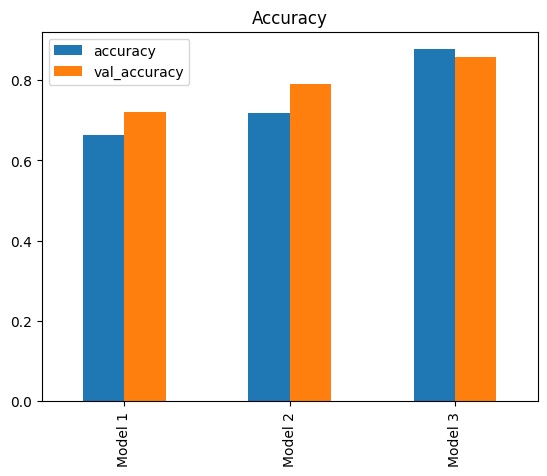

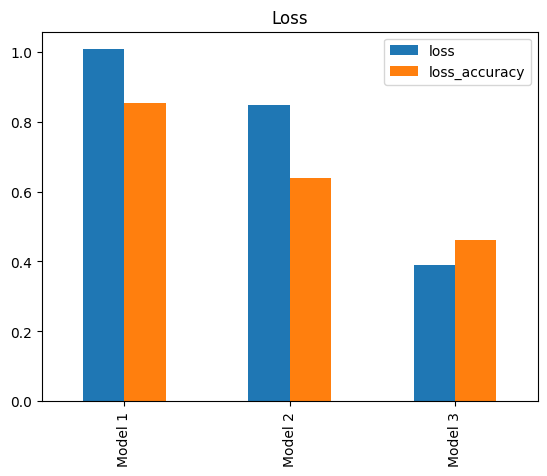

In [46]:
# plot the accuracy and loss of all models using df_results
df_results.plot(kind='bar', y=['accuracy', 'val_accuracy'], title='Accuracy')
df_results.plot(kind='bar', y=['loss', 'loss_accuracy'], title='Loss')


In [29]:
# clear the session to release memory
#K.clear_session()


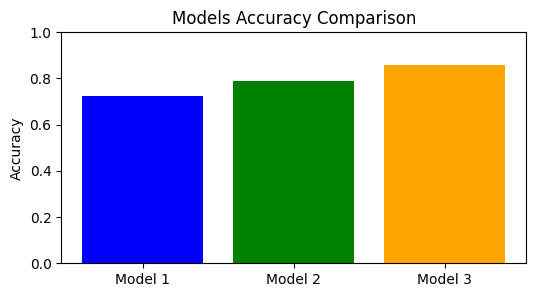

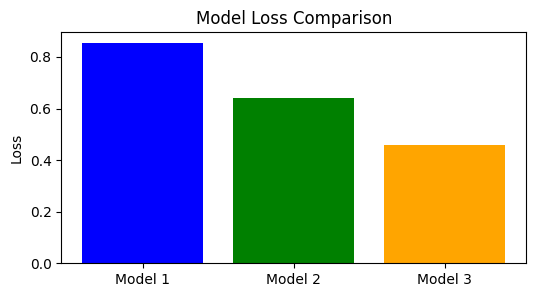

In [71]:
# Evaluate the models
results_model1 = model_factory.evaluate(model1, X_test, y_test_encoded)
results_model2 = model_factory.evaluate(model2, X_test, y_test_encoded)
results_model3 = model_factory.evaluate(model3, X_test, y_test_encoded)

# Extract metrics (accuracy, loss, etc.) for each model
accuracy_values = [results_model1[1], results_model2[1], results_model3[1]]
loss_values = [results_model1[0], results_model2[0], results_model3[0]]

# Plot accuracy
plt.figure(figsize=(6, 3))
plt.bar(['Model 1', 'Model 2', 'Model 3'], accuracy_values, color=['blue', 'green', 'orange'])
plt.title('Models Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit to match the accuracy range (0 to 1)
plt.show()

# Plot loss
plt.figure(figsize=(6, 3))
plt.bar(['Model 1', 'Model 2', 'Model 3'], loss_values, color=['blue', 'green', 'orange'])
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.show()

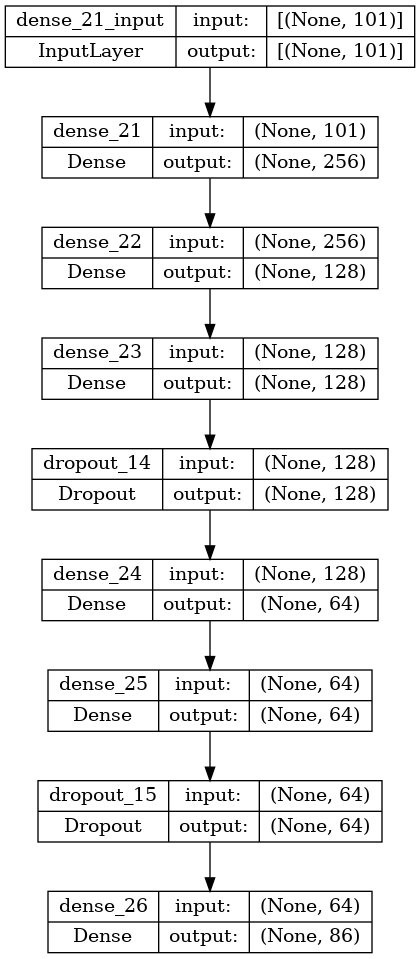

In [51]:
plot_model(model1, to_file='./images/ozkary-mlp-neural-network1.png', show_shapes=True, show_layer_names=True)
plot_model(model2, to_file='./images/ozkary-mlp-neural-network2.png', show_shapes=True, show_layer_names=True)
plot_model(model3, to_file='./images/ozkary-mlp-neural-network3.png', show_shapes=True, show_layer_names=True)

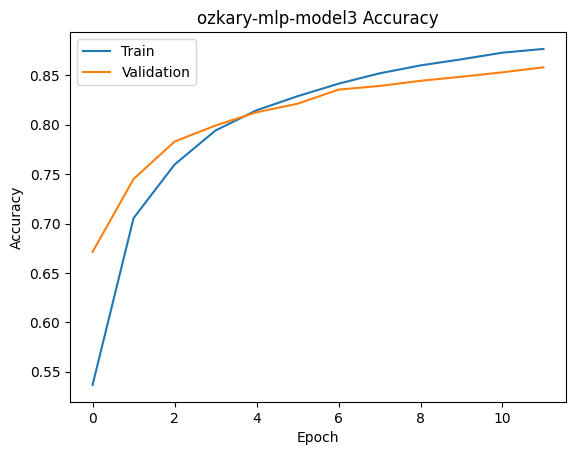

In [59]:
# plot model 3 accuracy and loss
model_factory.plot_accuracy('ozkary-mlp-model3', hist3)

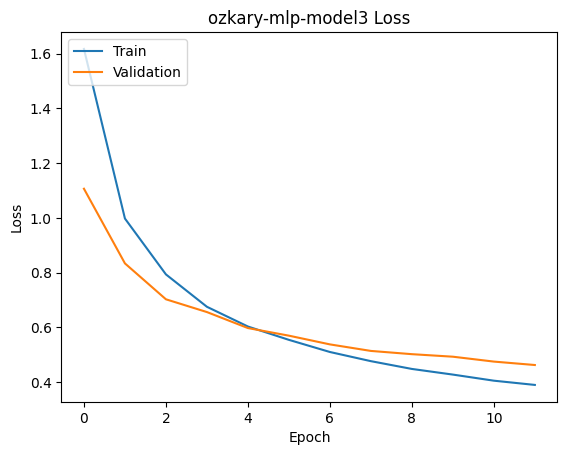

In [60]:
# plot model 3 loss
model_factory.plot_loss('ozkary-mlp-model3', hist3)

In [61]:
# save the model
model_factory.save_model(model3, './models/ozkary-ddi.h5')

/home/ozkary/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
# save the training notebook to code
!jupyter nbconvert --to script data_train_mlp.ipynb

# move it to the ddi_lib folder
!mv data_train_mlp.py ./ddi_lib

/usr/bin/jupyter:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
[NbConvertApp] Converting notebook data_train_mlp.ipynb to script
[NbConvertApp] Writing 9507 bytes to data_train_mlp.py
